In [2]:
import json
import glob
import fsspec
import datetime
import pandas as pd
import pytz
import io
import ujson
import asyncio
import nest_asyncio
import numpy as np
import re
from kerchunk.combine import MultiZarrToZarr
import xarray as xr
import base64
from kerchunk.grib2 import parse_grib_idx, build_idx_grib_mapping, map_from_index, grib_tree, scan_grib
from dask.distributed import LocalCluster, Client, performance_report
import dask
from dask import delayed
import dask.bag as db
from pathlib import Path
import datatree
import s3fs
from gefsv12_retro_kerchunk.kerchunk_zarr import RetrospectivePull
from gefsv12_retro_kerchunk import utils as ut
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid',font_scale=1.3)

In [2]:
client = ut.start_dask_cluster(
    n_workers=4, threads_per_worker=2, memory_limit="6GiB"
)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 24.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:62767,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 24.00 GiB
Comm: tcp://127.0.0.1:62788,Total threads: 2
Dashboard: http://127.0.0.1:62793/status,Memory: 6.00 GiB
Nanny: tcp://127.0.0.1:62770,


In [3]:
basename = 's3://noaa-gefs-pds/gefs.20241029/00/atmos/pgrb2sp25/gespr.t00z.pgrb2s.0p25.f006'

In [4]:
fs_read = fsspec.filesystem('s3', anon=True, skip_instance_cache=True)
fs_local = fsspec.filesystem('', skip_instance_cache = True, use_listings_cache=False)

In [5]:
so = {"anon": True, "skip_instance_cache": True}
json_dir = 'X:/code/espr/assets/'

def gen_json(file_url):
    out = scan_grib(file_url, storage_options=so)   #create the reference using scan_grib
    for i, message in enumerate(out):
        key_ = [n for n in message['refs'].keys() if '0.0' in n]
        print(key_[0].split('/')[0]) # scan_grib outputs a list containing one reference per grib message
        if 'prmsl' in key_[0]:
            with fs_local.open(f"{json_dir}gefs_rt_representative.json", "w") as f: 
                f.write(ujson.dumps(message)) #write to file

In [6]:
gen_json(basename)

vis
gust
mslet
sp
st
soilw
sdwe
sde
sithick
t2m
d2m
r2
unknown
unknown
u10
v10
cpofp
tp
csnow
cicep
cfrzr
crain
mslhf
msshf
cape
cin
pwat
tcc
gh
sdswrf
sdlwrf
suswrf
sulwrf
sulwrf
hlcy
cape
cin
prmsl


In [7]:
reference_jsons = fs_local.ls(json_dir) #get list of file names

In [8]:
#combine individual references into single consolidated reference
mzz = MultiZarrToZarr([reference_jsons[0]],
                        concat_dims = ['valid_time'],
                        identical_dims=['latitude', 'longitude', 'step'])

In [9]:
mzz

In [10]:
d = mzz.translate()

x:\anaconda3\envs\espr\Lib\site-packages\kerchunk\combine.py:379: UserWarning: Concatenated coordinate 'valid_time' contains less than expectednumber of values across the datasets: [1730181600]
  warnings.warn(


In [11]:
#open dataset as zarr object using fsspec reference file system and xarray
fs = fsspec.filesystem("reference", fo=d, remote_protocol='s3', remote_options={'anon':True})
m = fs.get_mapper("")
ds_one = xr.open_dataset(m, engine="zarr", backend_kwargs=dict(consolidated=False), 
                      chunks={'valid_time':1})

In [12]:
ds_one

<xarray.Dataset> Size: 8MB
Dimensions:     (latitude: 721, longitude: 1440, valid_time: 1)
Coordinates:
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    meanSea     (valid_time) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    step        timedelta64[ns] 8B ...
    time        (valid_time) datetime64[ns] 8B dask.array<chunksize=(1,), meta=np.ndarray>
  * valid_time  (valid_time) datetime64[ns] 8B 2024-10-29T06:00:00
Data variables:
    prmsl       (valid_time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_edition:            2
    GRIB_subCentre:          2
    institution:             US National Weather Service - NCEP

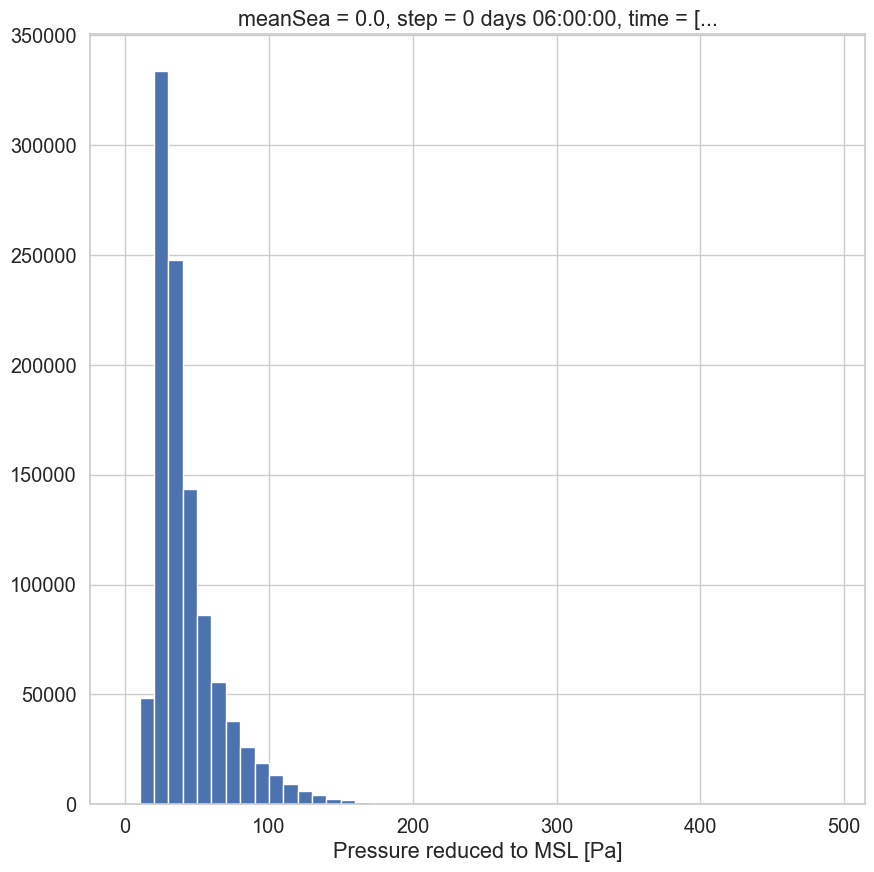

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
ds_one['prmsl'].plot.hist(bins=list(np.arange(0,500,10)),ax=ax)
plt.show()

In [14]:
retro = RetrospectivePull(fhour=9)
retro.generate_json_files()
ds = retro.generate_kerchunk(ds=True)

x:\anaconda3\envs\espr\Lib\site-packages\kerchunk\combine.py:379: UserWarning: Concatenated coordinate 'step' contains less than expectednumber of values across the datasets: [30]
  warnings.warn(


In [9]:
glob.glob(retro.directory+'/*')

['C:\\Users\\TMAN1_~1\\AppData\\Local\\Temp\\tmpn2p3zpbj\\pres_msl_2000101900_c00_06.json',
 'C:\\Users\\TMAN1_~1\\AppData\\Local\\Temp\\tmpn2p3zpbj\\pres_msl_2000101900_p01_06.json',
 'C:\\Users\\TMAN1_~1\\AppData\\Local\\Temp\\tmpn2p3zpbj\\pres_msl_2000101900_p02_06.json',
 'C:\\Users\\TMAN1_~1\\AppData\\Local\\Temp\\tmpn2p3zpbj\\pres_msl_2000101900_p03_06.json',
 'C:\\Users\\TMAN1_~1\\AppData\\Local\\Temp\\tmpn2p3zpbj\\pres_msl_2000101900_p04_06.json',
 'C:\\Users\\TMAN1_~1\\AppData\\Local\\Temp\\tmpn2p3zpbj\\pres_msl_2000102000_c00_06.json',
 'C:\\Users\\TMAN1_~1\\AppData\\Local\\Temp\\tmpn2p3zpbj\\pres_msl_2000102000_p01_06.json',
 'C:\\Users\\TMAN1_~1\\AppData\\Local\\Temp\\tmpn2p3zpbj\\pres_msl_2000102000_p02_06.json',
 'C:\\Users\\TMAN1_~1\\AppData\\Local\\Temp\\tmpn2p3zpbj\\pres_msl_2000102000_p03_06.json',
 'C:\\Users\\TMAN1_~1\\AppData\\Local\\Temp\\tmpn2p3zpbj\\pres_msl_2000102000_p04_06.json',
 'C:\\Users\\TMAN1_~1\\AppData\\Local\\Temp\\tmpn2p3zpbj\\pres_msl_2000102100_c0

In [15]:
ds

<xarray.Dataset> Size: 17GB
Dimensions:     (latitude: 721, longitude: 1440, member: 5, step: 1, time: 420)
Coordinates:
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    meanSea     (member, step, time) float64 17kB dask.array<chunksize=(2, 1, 6), meta=np.ndarray>
  * member      (member) object 40B 'c00' 'p01' 'p02' 'p03' 'p04'
    number      (member, step, time) int64 17kB dask.array<chunksize=(2, 1, 6), meta=np.ndarray>
  * step        (step) timedelta64[ns] 8B 1 days 06:00:00
  * time        (time) datetime64[ns] 3kB 2000-10-19 2000-10-20 ... 2019-11-08
    valid_time  (member, step, time) datetime64[ns] 17kB dask.array<chunksize=(2, 1, 6), meta=np.ndarray>
Data variables:
    msl         (member, step, time, latitude, longitude) float64 17GB dask.array<chunksize=(2, 1, 6, 721, 1440), meta=np.ndarray>
Attributes:
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_edition:            2
    GRIB_subCentre:          2
    institution:             US National Weather Service - NCEP

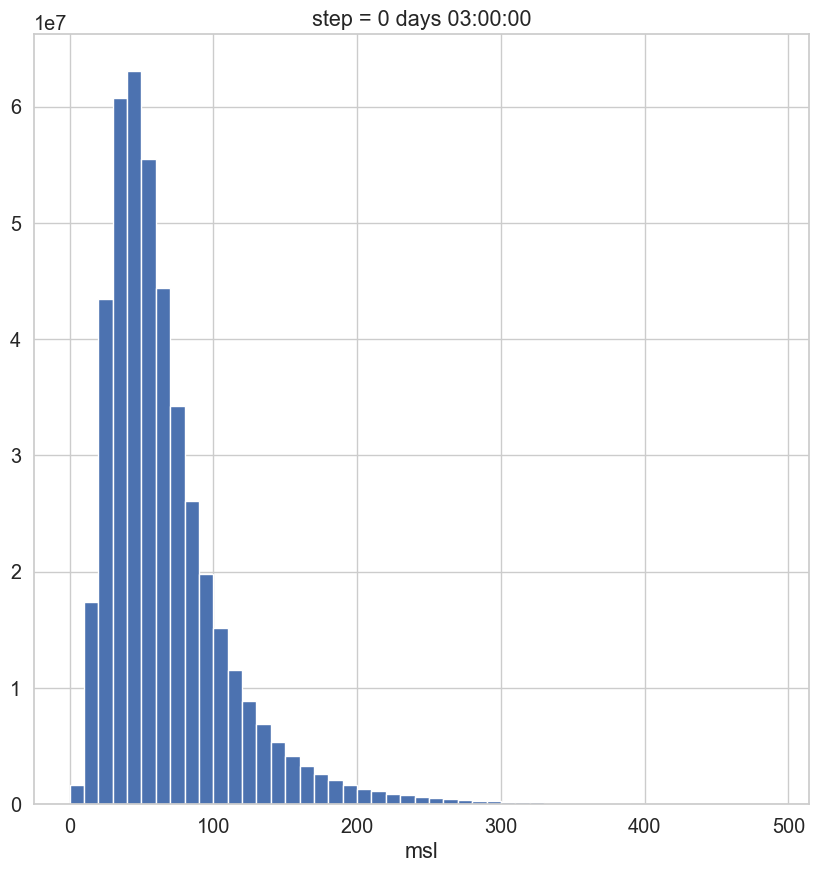

In [27]:
fig, ax = plt.subplots(figsize=(10,10))
ds['msl'].std(dim='member').plot(bins=list(np.arange(0,500,10)),ax=ax)
plt.show()